In [1]:
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

url = "https://www.kaggle.com/api/v1/datasets/download/srijan1upadhyay/startup-valuation-dataset"

response = requests.get(url, allow_redirects=True)
if response.status_code == 200:
    print("Download completed ✅")
else:
    raise Exception(f"failed download: {response.status_code}")

zip_file = zipfile.ZipFile(io.BytesIO(response.content))
print("Archivos en el zip:", zip_file.namelist())

csv_filename = zip_file.namelist()[0]

df = pd.read_csv(zip_file.open(csv_filename))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("rows for model:", len(df))




Download completed ✅
Archivos en el zip: ['startup_valuation_dataset.csv']
rows for model: 50000


Data Analysis

Basic exploration data


In [2]:
df.columns

Index(['startup_id', 'startup_name', 'founded_year', 'country', 'region',
       'industry', 'funding_round', 'funding_amount_usd', 'funding_date',
       'lead_investor', 'co_investors', 'employee_count',
       'estimated_revenue_usd', 'estimated_valuation_usd', 'exited',
       'exit_type', 'tags'],
      dtype='object')

In [2]:
df.shape

(50000, 17)

In [3]:
round(df.describe(),2)

,founded_year,funding_amount_usd,employee_count,estimated_revenue_usd,estimated_valuation_usd
count,49950,49950,49950,49950,49950
mean,2014,811842965,502,223212830,4887317283
std,5,1273332522,289,401527746,8276942494
min,2005,3925000,2,622017,12794686
25%,2009,210187750,252,45549718,1092665221
50%,2014,439775000,503,106864489,2441790700
75%,2019,926249750,752,245513627,5465277689
max,2023,61037115000,1000,23041887506,322060497842


In [ ]:
df.dtypes

startup_id                  object
startup_name                object
founded_year                 int64
country                     object
region                      object
industry                    object
funding_round               object
funding_amount_usd           int64
funding_date                object
lead_investor               object
co_investors                object
employee_count               int64
estimated_revenue_usd      float64
estimated_valuation_usd    float64
exited                        bool
exit_type                   object
tags                        object
dtype: object

In [40]:
df.sample(5)

,startup_id,startup_name,founded_year,country,region,industry,funding_round,funding_amount_usd,funding_date,lead_investor,co_investors,employee_count,estimated_revenue_usd,estimated_valuation_usd,exited,exit_type,tags
6669,778e17b5-c322-44e6-a73a-ae1e94d6739d,"Schneider, Hopkins and Hansen",2022,Jamaica,Europe,AI/ML,Series C,2730416000,2022-01-20,Accel,"Index Ventures, Accel",269,648723367,23554233884,True,IPO,"EdTech, Mobile, SaaS, AI, B2C"
27128,a2056c46-6e57-47f7-b2c3-17baa2b56340,Murphy-Lawson,2006,Madagascar,Asia,E-commerce,IPO,903950000,2016-05-31,Andreessen Horowitz,"Y Combinator, Tiger Global, Index Ventures",370,281603428,8354963401,False,NaN,"SaaS, Mobile, Blockchain, Marketplace, IoT"
2713,211fb8b9-78cc-4538-b1b2-a42cc6c2e255,Ali LLC,2011,Aruba,Oceania,Logistics,Series B,406263000,2015-11-22,Andreessen Horowitz,"SoftBank, Index Ventures",621,25614287,3054516223,True,NaN,"Cloud, AI, B2B, Mobile"
2405,80cb9625-59b3-4abb-86f8-c59843d5da13,Flores and Sons,2013,Bulgaria,Latin America,Logistics,Series A,373474000,2019-12-20,Tiger Global,Accel,651,112905865,1030957160,True,Acquisition,"EdTech, Cloud, HealthTech"
22672,86adb3d6-5bdf-483a-a2ce-1e924c44c21d,Donovan-Taylor,2015,Tuvalu,North America,Logistics,Series A,1668810000,2018-06-12,Sequoia,"Tiger Global, SoftBank, Sequoia",892,492918416,15818431623,False,NaN,"Marketplace, IoT, B2B, EdTech"


In [2]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

def preprocess_startup_data(df, top_n_tags=None):
    """
    Limpia y transforma el dataset de startups:
    - Convierte columnas monetarias a float
    - Procesa columnas de fecha (día, mes, año, etc.)
    - Convierte co_investors en cantidad total de inversores
    - Separa y codifica tags (one-hot, opcionalmente limitando a top N)
    - One-hot encoding para variables categóricas
    - Elimina columnas irrelevantes
    """
    df = df.copy()

    # 1. Limpieza de montos en USD
    cash_cols = ['funding_amount_usd', 'estimated_revenue_usd', 'estimated_valuation_usd']
    for col in cash_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

    # 2. Procesamiento de fechas
    if 'funding_date' in df.columns:
        df['funding_date'] = pd.to_datetime(df['funding_date'], errors='coerce')
        df['funding_date_day'] = df['funding_date'].dt.day.fillna(0).astype('int32')
        df['funding_date_month'] = df['funding_date'].dt.month.fillna(0).astype('int32')
        df['funding_date_year'] = df['funding_date'].dt.year.fillna(0).astype('int32')
        df['funding_date_weekday'] = df['funding_date'].dt.weekday.fillna(0).astype('int32')
        df['funding_date_quarter'] = df['funding_date'].dt.quarter.fillna(0).astype('int32')
        df.drop(columns=['funding_date'], inplace=True)

    # 3. Procesar co_investors → convertir a número de inversores
    if 'co_investors' in df.columns:
        df['co_investors'] = df['co_investors'].fillna('')
        df['co_investors_count'] = df['co_investors'].apply(
            lambda x: len([i.strip() for i in x.split(',') if i.strip() != ''])
        )
        df.drop(columns=['co_investors'], inplace=True)

    # 4. Procesar tags con one-hot encoding (o top N)
    if 'tags' in df.columns:
        df['tags'] = df['tags'].fillna('').apply(lambda x: [t.strip() for t in x.split(',') if t.strip() != ''])
        if top_n_tags is not None:
            # Limitar a los N tags más frecuentes
            all_tags = df['tags'].explode()
            top_tags = [t for t, _ in Counter(all_tags).most_common(top_n_tags)]
            for t in top_tags:
                df[f"tag_{t}"] = df['tags'].apply(lambda tags_list: int(t in tags_list))
        else:
            # One-hot para todos los tags
            mlb_tags = MultiLabelBinarizer()
            tags_encoded = pd.DataFrame(
                mlb_tags.fit_transform(df['tags']),
                columns=[f"tag_{t}" for t in mlb_tags.classes_],
                index=df.index
            )
            df = pd.concat([df, tags_encoded], axis=1)
        df.drop(columns=['tags'], inplace=True)

    # 5. One-hot encoding para variables categóricas simples
    categorical_cols = [
        'country', 'region', 'industry', 'funding_round',
        'lead_investor', 'exit_type'
    ]
    existing_cats = [c for c in categorical_cols if c in df.columns]
    df = pd.get_dummies(df, columns=existing_cats, drop_first=True)

    # 6. Eliminar columnas irrelevantes o con IDs
    drop_cols = ['startup_id', 'startup_name']
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

    # 7. Asegurar tipos numéricos
    for col in df.select_dtypes(include='object').columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        except:
            pass

    return df


In [3]:
df['exit_type'] = df['exit_type'].fillna('No Exit')

In [4]:
df=preprocess_startup_data(df)


In [5]:
df.head(10)

,founded_year,funding_amount_usd,employee_count,estimated_revenue_usd,estimated_valuation_usd,exited,funding_date_day,funding_date_month,funding_date_year,funding_date_weekday,funding_date_quarter,co_investors_count,tag_AI,tag_B2B,tag_B2C,tag_Blockchain,tag_Cloud,tag_EdTech,tag_HealthTech,tag_IoT,tag_Marketplace,tag_Mobile,tag_SaaS,country_Albania,country_Algeria,country_American Samoa,country_Andorra,country_Angola,country_Anguilla,country_Antarctica (the territory South of 60 deg S),country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bosnia and Herzegovina,country_Botswana,country_Bouvet Island (Bouvetoya),country_Brazil,country_British Indian Ocean Territory (Chagos Archipelago),country_British Virgin Islands,country_Brunei Darussalam,country_Bulgaria,country_Burkina Faso,country_Burundi,country_Cambodia,country_Cameroon,country_Canada,country_Cape Verde,country_Cayman Islands,country_Central African Republic,country_Chad,country_Chile,country_China,country_Christmas Island,country_Cocos (Keeling) Islands,country_Colombia,country_Comoros,country_Congo,country_Cook Islands,country_Costa Rica,country_Cote d'Ivoire,country_Croatia,country_Cuba,country_Cyprus,country_Czech Republic,country_Denmark,country_Djibouti,country_Dominica,country_Dominican Republic,country_Ecuador,country_Egypt,country_El Salvador,country_Equatorial Guinea,country_Eritrea,country_Estonia,country_Ethiopia,country_Falkland Islands (Malvinas),country_Faroe Islands,country_Fiji,country_Finland,country_France,country_French Guiana,country_French Polynesia,country_French Southern Territories,country_Gabon,country_Gambia,country_Georgia,country_Germany,country_Ghana,country_Gibraltar,country_Greece,country_Greenland,country_Grenada,country_Guadeloupe,country_Guam,country_Guatemala,country_Guernsey,country_Guinea,country_Guinea-Bissau,country_Guyana,country_Haiti,country_Heard Island and McDonald Islands,country_Holy See (Vatican City State),country_Honduras,country_Hong Kong,country_Hungary,country_Iceland,country_India,country_Indonesia,country_Iran,country_Iraq,country_Ireland,country_Isle of Man,country_Israel,country_Italy,country_Jamaica,country_Japan,country_Jersey,country_Jordan,country_Kazakhstan,country_Kenya,country_Kiribati,country_Korea,country_Kuwait,country_Kyrgyz Republic,country_Lao People's Democratic Republic,country_Latvia,country_Lebanon,country_Lesotho,country_Liberia,country_Libyan Arab Jamahiriya,country_Liechtenstein,country_Lithuania,country_Luxembourg,country_Macao,country_Madagascar,country_Malawi,country_Malaysia,country_Maldives,country_Mali,country_Malta,country_Marshall Islands,country_Martinique,country_Mauritania,country_Mauritius,country_Mayotte,country_Mexico,country_Micronesia,country_Moldova,country_Monaco,country_Mongolia,country_Montenegro,country_Montserrat,country_Morocco,country_Mozambique,country_Myanmar,country_Namibia,country_Nauru,country_Nepal,country_Netherlands,country_Netherlands Antilles,country_New Caledonia,country_New Zealand,country_Nicaragua,country_Niger,country_Nigeria,country_Niue,country_Norfolk Island,country_North Macedonia,country_Northern Mariana Islands,country_Norway,country_Oman,country_Pakistan,country_Palau,country_Palestinian Territory,country_Panama,country_Papua New Guinea,country_Paraguay,country_Peru,country_Philippines,country_Pitcairn Islands,country_Poland,country_Portugal,country_Puerto Rico,country_Qatar,country_Reunion,country_Romania,country_Russian Federation,country_Rwanda,country_Saint Barthelemy,country_Saint Helena,country_Saint Kitts and Nevis,country_Saint Lucia,country_Saint Martin,country_Saint Pierre and Miquelon,country_Saint Vincent and the Grenadines,country_Samoa,country_San Marino,country_Sao Tome and Princip

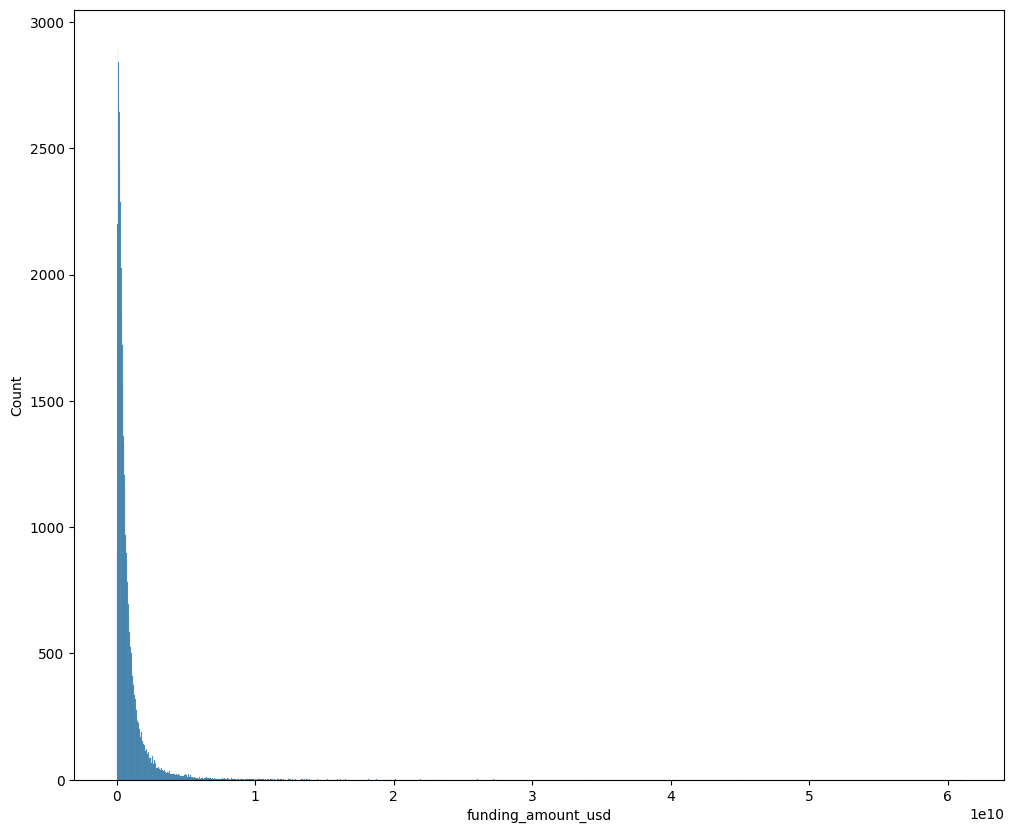

In [13]:
plt.figure(figsize=(12, 10))
sns.histplot(x='funding_amount_usd', data=df)
plt.show()


In [6]:
aliquota = df.sample(n=50, random_state=32)
aliquota.to_csv("aliquota_test.csv", index=False)

df_train = df.drop(aliquota.index).reset_index(drop=True)
df=df_train

In [7]:
df['exit_type_IPO'].value_counts()

exit_type_IPO
False    47422
True      2528
Name: count, dtype: int64

In [31]:
df.shape

(49950, 290)

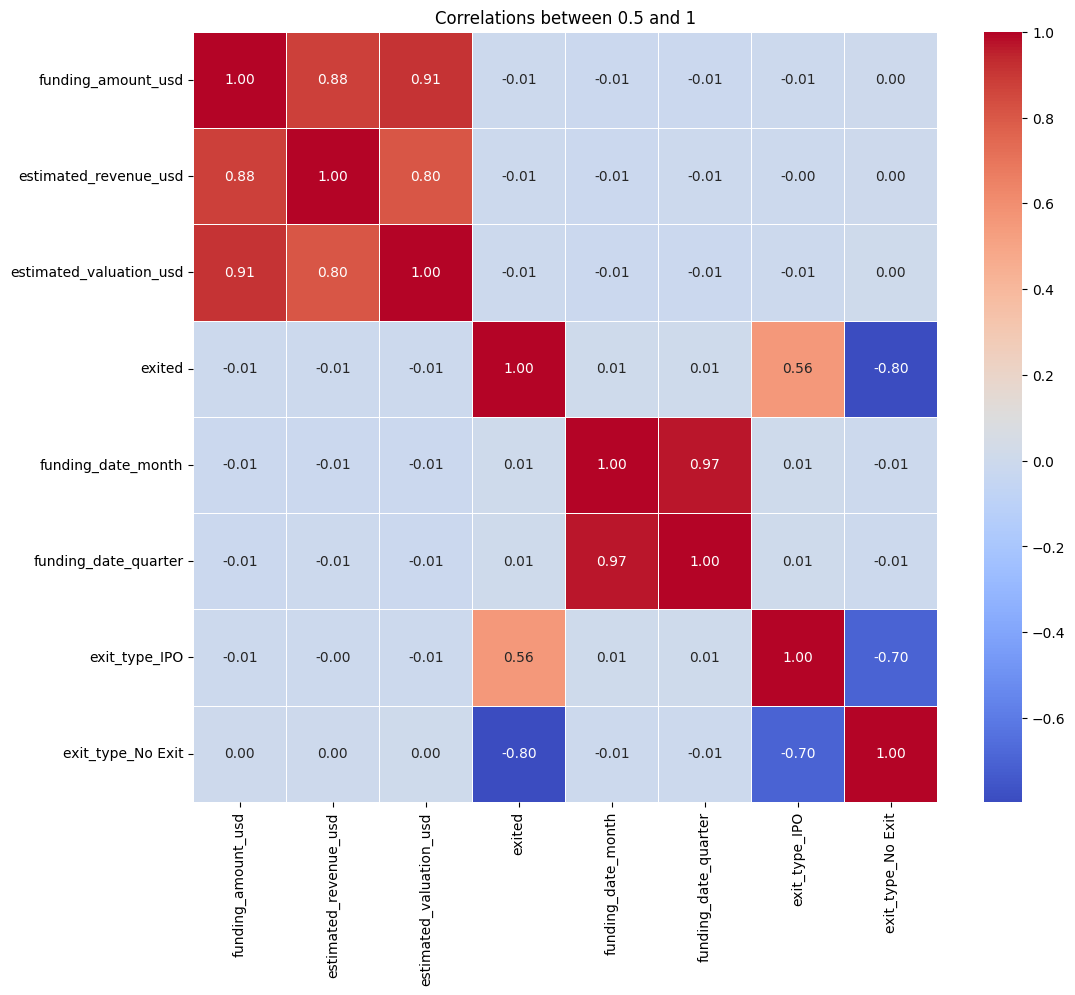

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular correlaciones
correlation_matrix = df.corr(numeric_only=True)

# Mantener solo correlaciones entre 0.5 y 1 (sin incluir 1)
mask = (correlation_matrix.abs() > 0.7) & (correlation_matrix.abs() < 1)

# Filtrar filas y columnas relevantes
strong_corr = correlation_matrix.loc[
    mask.any(axis=1),
    mask.any(axis=0)
]

# Graficar
plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlations between 0.5 and 1')
plt.show()





XGBoost Classifier

In [8]:
import pandas as pd
import random
import time
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

y = df['exit_type_IPO']  # target
X = df.drop('exit_type_IPO', axis=1)  # features

def test_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

results = []
start_total = time.time()

for i in range(1, 101):
    print(f"Ejecutando iteración {i}/100...")
    start_iter = time.time()


    e = random.randint(10, 300)   
    d = random.randint(3, 15)     
    r = random.randint(1, 300)    

   
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=r, stratify=y
    )
    original_distribution = dict(Counter(y_train))


    smote = SMOTE(random_state=r)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    

    res_distribution = dict(Counter(y_train_res))

    xgb_clf = XGBClassifier(
        n_estimators=e,
        max_depth=d,
        random_state=r,
        eval_metric='logloss',
        n_jobs=-1
    )
    xgb_metrics = test_model(xgb_clf, X_train_res, y_train_res, X_test, y_test)

    results.append({
        'n_estimators': e,
        'max_depth': d,
        'random_state': r,
        'original_distribution': original_distribution,
        'resampled_distribution': res_distribution,
        'xgb_accuracy': xgb_metrics['accuracy'],
        'xgb_precision': xgb_metrics['precision'],
        'xgb_recall': xgb_metrics['recall'],
        'xgb_f1_score': xgb_metrics['f1_score']
    })

    end_iter = time.time()
    print(f"Iteración {i} completada en {(end_iter - start_iter)/60:.2f} minutos.\n")

end_total = time.time()
print(f"Proceso completo en {(end_total - start_total)/60:.2f} minutos.")

results_df = pd.DataFrame(results)


Ejecutando iteración 1/100...
Iteración 1 completada en 0.05 minutos.

Ejecutando iteración 2/100...
Iteración 2 completada en 0.05 minutos.

Ejecutando iteración 3/100...
Iteración 3 completada en 0.04 minutos.

Ejecutando iteración 4/100...
Iteración 4 completada en 0.06 minutos.

Ejecutando iteración 5/100...
Iteración 5 completada en 0.03 minutos.

Ejecutando iteración 6/100...
Iteración 6 completada en 0.04 minutos.

Ejecutando iteración 7/100...
Iteración 7 completada en 0.04 minutos.

Ejecutando iteración 8/100...
Iteración 8 completada en 0.03 minutos.

Ejecutando iteración 9/100...
Iteración 9 completada en 0.03 minutos.

Ejecutando iteración 10/100...
Iteración 10 completada en 0.03 minutos.

Ejecutando iteración 11/100...
Iteración 11 completada en 0.06 minutos.

Ejecutando iteración 12/100...
Iteración 12 completada en 0.06 minutos.

Ejecutando iteración 13/100...
Iteración 13 completada en 0.02 minutos.

Ejecutando iteración 14/100...
Iteración 14 completada en 0.03 minuto

In [9]:
results_df.sort_values(by='xgb_accuracy',ascending=False).head(3)

,n_estimators,max_depth,random_state,original_distribution,resampled_distribution,xgb_accuracy,xgb_precision,xgb_recall,xgb_f1_score
1,294,8,37,"{False: 33195, True: 1770}","{False: 33195, True: 33195}",0.954821,0.956799,0.954821,0.955750
13,72,12,186,"{False: 33195, True: 1770}","{False: 33195, True: 33195}",0.954688,0.957610,0.954688,0.956022
46,142,8,186,"{False: 33195, True: 1770}","{False: 33195, True: 33195}",0.954421,0.956239,0.954421,0.955280


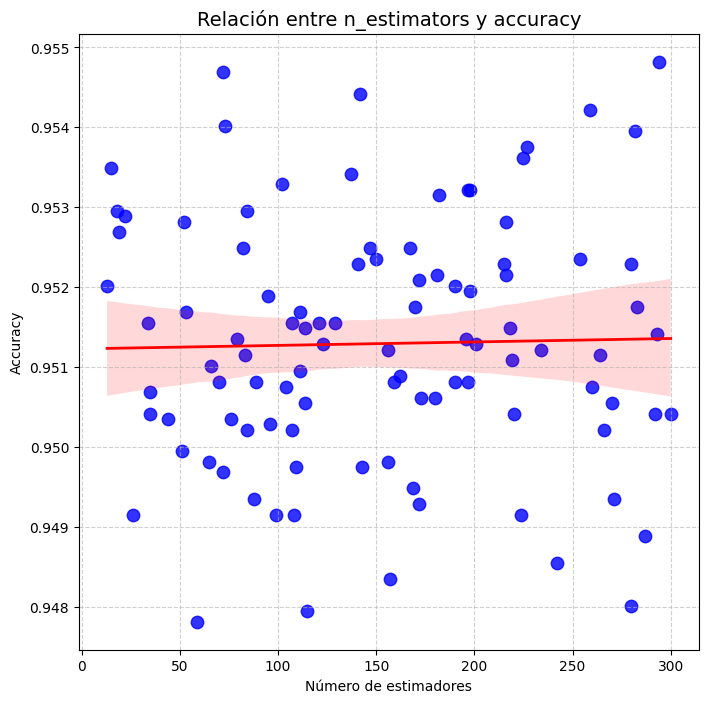

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.regplot(
    x="n_estimators", 
    y="xgb_accuracy", 
    data=results_df,
    scatter_kws={"s": 80, "color": "blue"},
    line_kws={"color": "red", "linewidth": 2}
)
plt.title("Relación entre n_estimators y accuracy", fontsize=14)
plt.xlabel("Número de estimadores")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Final model

In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y = df['exit_type_IPO']  # target
X = df.drop('exit_type_IPO', axis=1)  # features

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=37, stratify=y
)

print("original distribution:", dict(Counter(y_train)))


smote = SMOTE(random_state=247)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("distribution after smote:", dict(Counter(y_train_res)))

# i use the best hyperparameters of my for loop model
model = XGBClassifier(
    n_estimators=294,
    max_depth=8,
    random_state=37,
    eval_metric='logloss',
    n_jobs=-1
)

model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


original distribution: {False: 33195, True: 1770}
distribution after smote: {False: 33195, True: 33195}
Accuracy: 0.9535
Precision: 0.9561
Recall: 0.9535
F1-score: 0.9547


Now, we test the modulo with our aliquota 

In [12]:
df_test=pd.read_csv(r'C:\Users\alejo\Desktop\BYUI\CSE-310 LOCAL\CSE-310\personal-project\module-1-ML-PREAPPROVEDAPP\aliquota_test.csv')

df_test.shape


(50, 290)

In [16]:
df_test.head(4)

,founded_year,funding_amount_usd,employee_count,estimated_revenue_usd,estimated_valuation_usd,exited,funding_date_day,funding_date_month,funding_date_year,funding_date_weekday,funding_date_quarter,co_investors_count,tag_AI,tag_B2B,tag_B2C,tag_Blockchain,tag_Cloud,tag_EdTech,tag_HealthTech,tag_IoT,tag_Marketplace,tag_Mobile,tag_SaaS,country_Albania,country_Algeria,country_American Samoa,country_Andorra,country_Angola,country_Anguilla,country_Antarctica (the territory South of 60 deg S),country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bosnia and Herzegovina,country_Botswana,country_Bouvet Island (Bouvetoya),country_Brazil,country_British Indian Ocean Territory (Chagos Archipelago),country_British Virgin Islands,country_Brunei Darussalam,country_Bulgaria,country_Burkina Faso,country_Burundi,country_Cambodia,country_Cameroon,country_Canada,country_Cape Verde,country_Cayman Islands,country_Central African Republic,country_Chad,country_Chile,country_China,country_Christmas Island,country_Cocos (Keeling) Islands,country_Colombia,country_Comoros,country_Congo,country_Cook Islands,country_Costa Rica,country_Cote d'Ivoire,country_Croatia,country_Cuba,country_Cyprus,country_Czech Republic,country_Denmark,country_Djibouti,country_Dominica,country_Dominican Republic,country_Ecuador,country_Egypt,country_El Salvador,country_Equatorial Guinea,country_Eritrea,country_Estonia,country_Ethiopia,country_Falkland Islands (Malvinas),country_Faroe Islands,country_Fiji,country_Finland,country_France,country_French Guiana,country_French Polynesia,country_French Southern Territories,country_Gabon,country_Gambia,country_Georgia,country_Germany,country_Ghana,country_Gibraltar,country_Greece,country_Greenland,country_Grenada,country_Guadeloupe,country_Guam,country_Guatemala,country_Guernsey,country_Guinea,country_Guinea-Bissau,country_Guyana,country_Haiti,country_Heard Island and McDonald Islands,country_Holy See (Vatican City State),country_Honduras,country_Hong Kong,country_Hungary,country_Iceland,country_India,country_Indonesia,country_Iran,country_Iraq,country_Ireland,country_Isle of Man,country_Israel,country_Italy,country_Jamaica,country_Japan,country_Jersey,country_Jordan,country_Kazakhstan,country_Kenya,country_Kiribati,country_Korea,country_Kuwait,country_Kyrgyz Republic,country_Lao People's Democratic Republic,country_Latvia,country_Lebanon,country_Lesotho,country_Liberia,country_Libyan Arab Jamahiriya,country_Liechtenstein,country_Lithuania,country_Luxembourg,country_Macao,country_Madagascar,country_Malawi,country_Malaysia,country_Maldives,country_Mali,country_Malta,country_Marshall Islands,country_Martinique,country_Mauritania,country_Mauritius,country_Mayotte,country_Mexico,country_Micronesia,country_Moldova,country_Monaco,country_Mongolia,country_Montenegro,country_Montserrat,country_Morocco,country_Mozambique,country_Myanmar,country_Namibia,country_Nauru,country_Nepal,country_Netherlands,country_Netherlands Antilles,country_New Caledonia,country_New Zealand,country_Nicaragua,country_Niger,country_Nigeria,country_Niue,country_Norfolk Island,country_North Macedonia,country_Northern Mariana Islands,country_Norway,country_Oman,country_Pakistan,country_Palau,country_Palestinian Territory,country_Panama,country_Papua New Guinea,country_Paraguay,country_Peru,country_Philippines,country_Pitcairn Islands,country_Poland,country_Portugal,country_Puerto Rico,country_Qatar,country_Reunion,country_Romania,country_Russian Federation,country_Rwanda,country_Saint Barthelemy,country_Saint Helena,country_Saint Kitts and Nevis,country_Saint Lucia,country_Saint Martin,country_Saint Pierre and Miquelon,country_Saint Vincent and the Grenadines,country_Samoa,country_San Marino,country_Sao Tome and Princip

In [17]:
df_test.shape

(50, 290)

In [13]:
df_predicction=df_test.drop("exit_type_IPO", axis=1).values
new_pred = model.predict(df_predicction)

predictions = pd.DataFrame(new_pred, columns=['exit_type_IPO'])

predictions.to_csv("exit_type_IPO-predictions.csv", index=False)

checking predicctions

Accuracy: 0.9800
Precision: 0.9900
Recall: 0.9800
F1-score: 0.9832
[[48  1]
 [ 0  1]]
[[0.97959184 0.02040816]
 [0.         1.        ]]


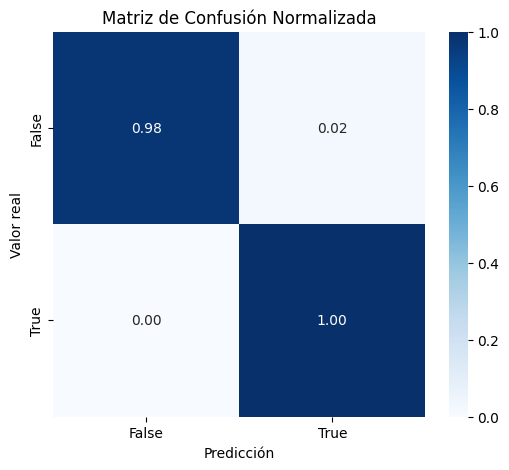

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

accuracy = accuracy_score(df_test['exit_type_IPO'],new_pred)
precision = precision_score(df_test['exit_type_IPO'], new_pred, average='weighted', zero_division=0)
recall = recall_score(df_test['exit_type_IPO'], new_pred, average='weighted', zero_division=0)
f1 = f1_score(df_test['exit_type_IPO'], new_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


cm = confusion_matrix(df_test['exit_type_IPO'],new_pred)
print(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=np.unique(df_test['exit_type_No Exit']),
            yticklabels=np.unique(df_test['exit_type_No Exit']))
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión Normalizada')
plt.show()


In [15]:
from sklearn.metrics import classification_report

print(classification_report(df_test['exit_type_IPO'], new_pred))


              precision    recall  f1-score   support

       False       1.00      0.98      0.99        49
        True       0.50      1.00      0.67         1

    accuracy                           0.98        50
   macro avg       0.75      0.99      0.83        50
weighted avg       0.99      0.98      0.98        50



In [16]:
model.save_model("investment-pred.json")
